# CASE 2. Classifier for detection of pneumonia using convolutional neural networks for inbalanced data

TEAM 10: 
Eliecer Diaz, Muskan Kaushik, and Zakaria Hasan

I. Background

Convolutional neural networks, so-called convnets (CNN)are essential, since providing a hint on how we (as humans) recognize images, but more importantly, they provide insights on computer vision implementation.
Convolutional networks are a type of algorithm used to classify images, it is surprisingly simple, although the adjustments and effective architectures can become somehow complicated. The idea behind is that the basic unit of input data comprises a 2D dimensional array, which can contain 1-3 or more colour channel is passed to a sequence of filters or kernels which extract features in the image to make it classifiable.

I.i. Objectives
- To learn to use convnets (CNN) and create a binary classifier for x-ray chest images.
- To build, fit and evaluate three different CNN models and compare their performances using an additional metric different from accuracy, e.g. sensitivity or specificity.
- To select the best model and explain the decision.

II. Methods

a. The dataset was provided by Kermany et al. (2018)from Mandeley Data repository. Dataset contains Chest X-Ray Images, concerning diagnosis of pneumonia. The data was split into a proportion 60:20:20, corresponding to training, validation and testing data by the authors.

b. Data exploration and processing comprised:
 1. rescaling each image, this was done using ImageGenerator function
 2. we used ImageGenerator function to resize each image, to obtain 150 by 150 pixels. 
 3. We shuffle images (except the test set) using Image generator functions.


In [1]:
import random 
import collections
random.seed(7)
import tensorflow as tf
from tensorflow.keras import layers,models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import SensitivityAtSpecificity
import matplotlib.pyplot as plt
from time import time
import tensorflow.keras.backend as k
import tensorflow.keras.callbacks as Callback
import matplotlib.pyplot as plot
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [4]:
# In case we have GPU e.g. Kaggle notebook we use it, otherwise we used CPU
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found in this computer")
else:
    print("Found GPU at: {}".format(device_name))


GPU device not found in this computer


In [16]:
#The data was read from three directories: train, validation and test # kaggle
train_dir = r'/home/elvi/Desktop/pneumonia2/train' #'/kaggle/input/pneumonia/pneumonia2/train'
val_dir = r'/home/elvi/Desktop/pneumonia2/validation'#'/kaggle/input/pneumonia/pneumonia2/validation'
test_dir = r'/home/elvi/Desktop/pneumonia2/test'#'/kaggle/input/pneumonia/pneumonia2/test'

In [15]:
os.listdir(train_dir)

['PNEUMONIA', 'NORMAL']

Examination of data balance implies to count how many photos 
corresponded to each category in each
directory: 'PNEUMONIA' or 'NORMAL'.

In [5]:
folders = ['train', 'validation', 'test']
for i in folders:
    print(i)
    Pneu = os.listdir('/home/elvi/Desktop/pneumonia2/{}/PNEUMONIA'.format(i)) # dir is your directory path
    Norm = os.listdir('/home/elvi/Desktop/pneumonia2/{}/NORMAL'.format(i)) 
    print(len(Pneu), len(Norm), ", % of sick / total =", 100*(len(Pneu)/(len(Pneu) + len(Norm))))

train
2564 949 , % of sick / total = 72.98605180757187
validation
855 317 , % of sick / total = 72.95221843003414
test
854 317 , % of sick / total = 72.92912040990606


It is possible to observe an imbalance between patients presenting Pneumonia and healthy ones.
This inbalance corresponded to a 73%. This implies that if we pick randomly a 
patient from the dataset, there is 73% of chance that presents Pneumonia.
This creates a benchmark, which needs to be improved by our classifier.

The following code represents the data generator function which helps to process the data, e.g.
rescale, resize images.

In [4]:
val_datagen = ImageDataGenerator(rescale=1./255)
test_generator = val_datagen.flow_from_directory(
        test_dir,
        #verbose = 0,
        shuffle=False,
        target_size = (150, 150),
        batch_size = 1, #<----tensorflow documentation
        class_mode='binary')

Found 1171 images belonging to 2 classes.


# CREATING MODELS

Model creation: Three models comprising similar architecture were constructed to test the effect of the batch_size. The batch_sizes used were 8, 32 and 64.
The model was compiled using binary_crossentropy as the loss function. The optimizer used was "rmsprop" with a learning rate of 0.0001.
Different metrics were used for fitting evaluation:
    1. ”Accuracy”
    2. ”Recall” 
    3. ”Precision” 

In [7]:
# Here the architecture that will vary according to the batch size
#as was requested in the lecture
def model_(neurones, batch): 
    
    #getting DIFFERENT metrics from Accuracy 
    Preci = tf.keras.metrics.Precision() 
    Recal = tf.keras.metrics.Recall() 
    
    #Image generator to rescale images
    train_datagen = ImageDataGenerator(rescale=1./255) # here we could use more features for augmentation
    #it was not necessary
    
    val_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size = (150, 150),
        batch_size = batch,
        class_mode = 'binary')
    
    val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size = (150, 150),
        batch_size = batch,
        class_mode='binary')
    
    try:
        with tf.device('/device:GPU:0'): #In case we have GPU use it:
        
            model = tf.keras.models.Sequential()
            model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)))
            model.add(MaxPooling2D((2, 2)))
            model.add(Conv2D(64, (3, 3), activation = 'relu'))
            model.add(MaxPooling2D((2, 2)))
            model.add(Conv2D(32, (3, 3), activation = 'relu'))
            model.add(MaxPooling2D((2, 2)))
            model.add(Conv2D(16, (3, 3), activation = 'relu'))
            model.add(MaxPooling2D((2, 2)))
            model.add(tf.keras.layers.Flatten())
            model.add(Dense(neurones, activation = 'relu'))
            model.add(Dense(1, activation = 'sigmoid'))

            model.compile(loss = 'binary_crossentropy',
                          optimizer = tf.keras.optimizers.RMSprop(lr = 1e-4),
                          metrics = ['acc', Preci, Recal])
            print("GPU/TPU IS ON")
    except: #when we dont have a GPU:
        
            model = tf.keras.models.Sequential()
            model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)))
            model.add(MaxPooling2D((2, 2)))
            model.add(Conv2D(64, (3, 3), activation = 'relu'))
            model.add(MaxPooling2D((2, 2)))
            model.add(Conv2D(32, (3, 3), activation = 'relu'))
            model.add(MaxPooling2D((2, 2)))
            model.add(Conv2D(16, (3, 3), activation = 'relu'))
            model.add(MaxPooling2D((2, 2)))
            model.add(tf.keras.layers.Flatten())
            model.add(Dense(neurones, activation = 'relu'))
            model.add(Dense(1, activation = 'sigmoid'))

            model.compile(loss = 'binary_crossentropy',
                          optimizer = tf.keras.optimizers.RMSprop(lr = 1e-4),
                          metrics = ['acc', Preci, Recal])
            print("NOT USING GPU")

    return model, train_generator, val_generator

In [8]:
%%capture
# Here some hyperparameters that were used:

neurones = [216] # neurones in the dense layer. This was implemented earlier, and perhaps
#useful in the future for us, we leave it here.
batches = [8, 32, 64] # List for batch size evaluation requested by S. Lukkarinen

# Dictionaries: e.g. Models{ model_216_8, model_216_32, and model_216_64}
models = {}
train_generators = {}
val_generators = {}

for ss in neurones: 
    for batch in batches:
        model_ss_batch = 'models_{}_{}'.format(ss, batch)  # creating the keys
        models[model_ss_batch] = model_(ss, batch) # appending the model to the key
        
        train_generator_ss_batch = 'train_generators_{}_{}'.format(ss, batch)  # creating the keys
        train_generators[train_generator_ss_batch] = model_(ss, batch) # appending the generator to the key
        
        val_generator_ss_batch = 'val_generators_{}_{}'.format(ss, batch)  # creating the keys
        val_generators[val_generator_ss_batch] = model_(ss, batch) # appending the model to the key       
        

In [9]:
# Only to check the correct appending in the dictionary 
print(models.keys()) #prints keys
print(train_generators.keys()) #prints keys
print(val_generators.keys()) #prints keys


dict_keys(['models_216_8', 'models_216_32', 'models_216_64'])
dict_keys(['train_generators_216_8', 'train_generators_216_32', 'train_generators_216_64'])
dict_keys(['val_generators_216_8', 'val_generators_216_32', 'val_generators_216_64'])


# **Model Fitting**
The dictionary "Final_model_i" contains the three models created, then each one model will be fitted, see line 7 according to its own key:

In [10]:
Final_models = {} # create a dictionary for FITTED models
for i in range(len(models)):
    print('MODEL:',i)
    Final_model_i = 'models_{}'.format(i)  # creating the keys
    
    # and here the fitting, and the model will be appended to the dictionary
    Final_models[Final_model_i] = models[list(models.keys())[i]][0].fit_generator(
        train_generators[list(train_generators.keys())[i]][1],
        steps_per_epoch = None, 
        verbose = 0,
        epochs = 20, # we used 20 since the process was very very slow..and metrics tend to stabilize at 10 epochs
        validation_data = val_generators[list(val_generators.keys())[i]][1],
        validation_steps = None, 
    )
    # saving the model
    models[list(models.keys())[i]][0].save("model{}.h5".format(i)) # save three models for evaluation

MODEL: 0
MODEL: 1
MODEL: 2


# III. Results

The evaluation to find the best model, with the best batch size, was done in three steps, for that we created three functions within the "class EVALUATE":

1. "fitting_evaluation" function: this will allow a visual inspection of the metrics (accuracy, precision, recall and loss); the model that exhibits less overfitting was chosen (Chollet 2017). 

2. "metric evaluation" function: it prints the scores metrics (accuracy, precision, recall and loss) on the test dataset. The model with the highest accuracy, precision and recall were chosen.

3. "confusion_threshold_evaluation" function: a. I print ROC curves, and AUC the model with the largest AUC was chosen. b. It plots the thresholds analyses on sensitivity and specificity)

We proceed as:

In [20]:
class EVALUATE:
    
    def fitting_evaluation():

        for i in range(len(Final_models)):
            print(i)
            models_key = Final_models.keys()
            model_key = [j  for  j in  models_key]
            metrics = Final_models[list(Final_models.keys())[i]].history.keys()
            metric = [k  for  k in  metrics]

            acc = Final_models[list(Final_models.keys())[i]].history[metric[1]]
            val_acc = Final_models[list(Final_models.keys())[i]].history[metric[5]]

            preci = Final_models[list(Final_models.keys())[i]].history[metric[2]]
            val_preci = Final_models[list(Final_models.keys())[i]].history[metric[6]]

            recal = Final_models[list(Final_models.keys())[i]].history[metric[3]]
            val_recal = Final_models[list(Final_models.keys())[i]].history[metric[7]]

            loss = Final_models[list(Final_models.keys())[i]].history[metric[0]]
            val_loss = Final_models[list(Final_models.keys())[i]].history[metric[4]]

            epochs = range(len(acc))

            fig, axs = plt.subplots(1, 4, figsize=(10, 9))


            axs[ 0].set_title('1. Accuracy')
            axs[ 0].plot(epochs, acc, 'bo-', label = 'Training acc')
            axs[ 0].plot(epochs, val_acc, 'r*-', label = 'Validation acc')

            axs[ 1].set_title('2. Precision ')
            axs[ 1].plot(epochs, preci, 'bo-', label = 'Precision_training ')
            axs[ 1].plot(epochs, val_preci, 'r*-', label = 'Precision validation')

            axs[ 2].set_title('3. Recall (sensitivity) ')
            axs[ 2].plot(epochs, recal, 'bo-', label = 'Recall training')
            axs[ 2].plot(epochs, val_recal, 'r*-', label = 'Recall validation')

            axs[ 3].set_title('4. Loss')
            axs[ 3].plot(epochs, loss, 'bo-', label = 'Training loss')
            axs[ 3].plot(epochs, val_loss, 'r*-', label = 'Validation loss')


            fig.suptitle(model_key[i], fontname="Times New Roman",fontweight="bold")
            fig.text(0.5, 0.04, 'EPOCH', ha='center', fontname="Times New Roman",fontweight="bold")
            plt.show()
    

    def metric_evaluation():
        test_generator.reset() # resetting generator
        for i in range(0, len(Final_models)):
            Loss, Accuracy, Preci, Recal = models[list(models.keys())[i]][0].evaluate_generator(generator=test_generator)
            print("Model", i)
            print('Loss: {}'.format(Loss), 'Accuracy: {}'.format(Accuracy), 'Precision: {}'.format(Preci), 'Recall: {}'.format(Recal))

    
    
    def confusion_threshold_evaluation(cutoff): 

        Y_labels = test_generator.classes

        for i in range(0, len(Final_models)):
            print("Prediction for model {}:".format(i))

            Y_pred = models[list(models.keys())[i]][0].predict_generator(test_generator)
            Y_pred_prob = Y_pred
            Y_pred = 1*(Y_pred.astype('float64') > cutoff)
            

            print('Confusion Matrix')
            print(confusion_matrix(Y_labels, Y_pred))
            print('Classification Report')
            target_names = ['1','0']
            print(classification_report(Y_labels, Y_pred, target_names=target_names))

            logit_roc_auc = roc_auc_score(Y_labels, Y_pred)

            fpr, tpr, thresholds = roc_curve(Y_labels, Y_pred_prob)


            fig, axs = plt.subplots(1, 2, figsize=(10, 10))

            axs[0].set_title('1. ROC')
            axs[0].plot(fpr, tpr, label='MODEL 1 (area = %0.2f)' % logit_roc_auc)
            axs[0].plot([0, 1], [0, 1],'r--')
            axs[0].set_xlabel('False Positive Rate')
            axs[0].set_ylabel('True Positive Rate')
            axs[0].legend(loc="lower right")

            axs[1].set_title('2. Threshold analysis ')
            axs[1].plot(thresholds, 1 - fpr, label = 'Specificity')
            axs[1].plot(thresholds, tpr, 'r*-', label = 'Sensitivity')
            axs[1].set_xlabel('Threshold')
            axs[1].set_ylabel('Metrics value')

            plt.show()        
        

1. Fitting evaluation: calling function 1

0


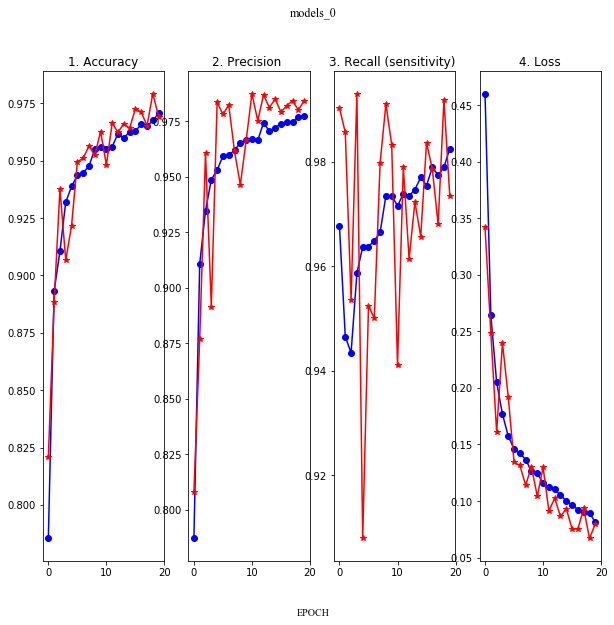

1


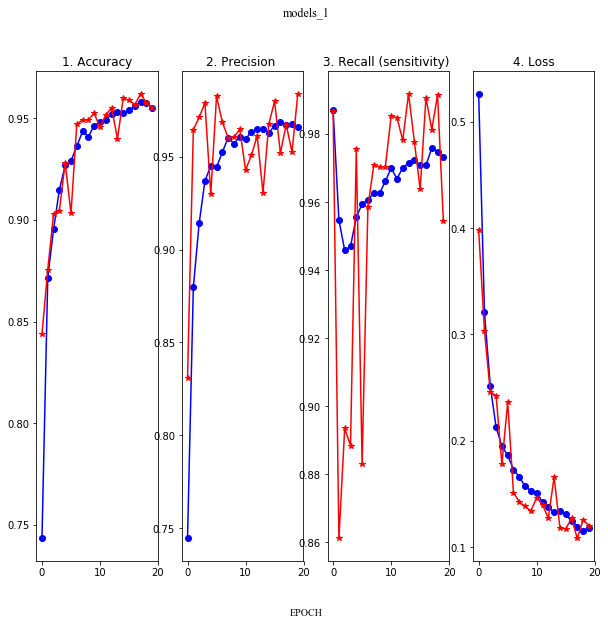

2


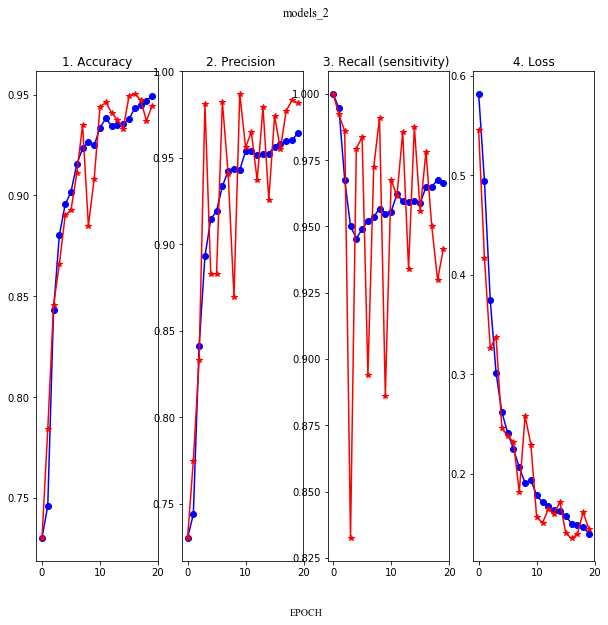

In [13]:
trail_0 = EVALUATE.fitting_evaluation()

Visual assessment of models above:

model_0: Accuracy and loss metrics do not show sign of overfitting. However, precision and recall showed a no apparent pattern either for correct fitting or overfitting. Recall showed some high flickering, making it challenging to judge fitting performance.

model_1: Similar to model_0, Accuracy a loss metrics, do not show signs of overfitting; however, recall and precision, exhibited less clear pattern to judge overfitting.

model_2: Although accuracy and loss metrics showed no signs of overfitting, they were less clear patterns of a proper fitting in comparison with the previous models. Precision and recall were ambiguous to analyze fitting performance.

From this evaluation step, we discard model_2. We keep model_0 and model_1 for further analysis step, "metric evaluation":

In [14]:
trail_1 = EVALUATE.metric_evaluation()

Model 0
Loss: 0.10937583655189508 Accuracy: 0.9649872183799744 Precision: 0.977673351764679 Recall: 0.9742388725280762
Model 1
Loss: 0.1291739613041655 Accuracy: 0.9521776437759399 Precision: 0.9807229042053223 Recall: 0.9531615972518921
Model 2
Loss: 0.13091884174218377 Accuracy: 0.9598633646965027 Precision: 0.9855595827102661 Recall: 0.9590163826942444


From this quick metric_evaluation, we see that the model_0 exhibited better Loss score (0.10) than model_1 (0.13). Similarly, accuracy, precision and recall were larger than model_1.

It is also worth noticing that our accuracy increment over 95% since the data is highly imbalanced, i.e. we found a baseline for this classifier of 73%, then this 95% represents an improvement of 22% for the classification performance.

For these reasons (visually and metric evaluation), we believe that model_0 (batch_size = 8) is performing better than model_1. The next step is to have a look at the ROC curves and the "threshold analysis", using out function confusion_threshold_evaluation(cutoff). Cutoff represents the decision boundary probability (Chollet 2017, Gerón 2019) for a classifier.

In [5]:
# Loading model 0, for tunning further evaluation, i.e. changing
# cutoff = decision boundary probability

loaded_model = tf.keras.models.load_model('model0.h5') 


Prediction for model 0:
Confusion Matrix
[[298  19]
 [ 22 832]]
Classification Report
              precision    recall  f1-score   support

           1       0.93      0.94      0.94       317
           0       0.98      0.97      0.98       854

   micro avg       0.96      0.96      0.96      1171
   macro avg       0.95      0.96      0.96      1171
weighted avg       0.97      0.96      0.97      1171



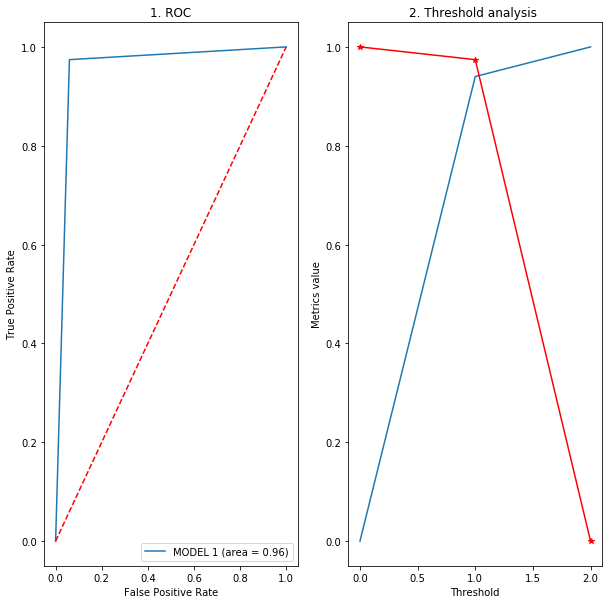

Prediction for model 1:
Confusion Matrix
[[301  16]
 [ 40 814]]
Classification Report
              precision    recall  f1-score   support

           1       0.88      0.95      0.91       317
           0       0.98      0.95      0.97       854

   micro avg       0.95      0.95      0.95      1171
   macro avg       0.93      0.95      0.94      1171
weighted avg       0.95      0.95      0.95      1171



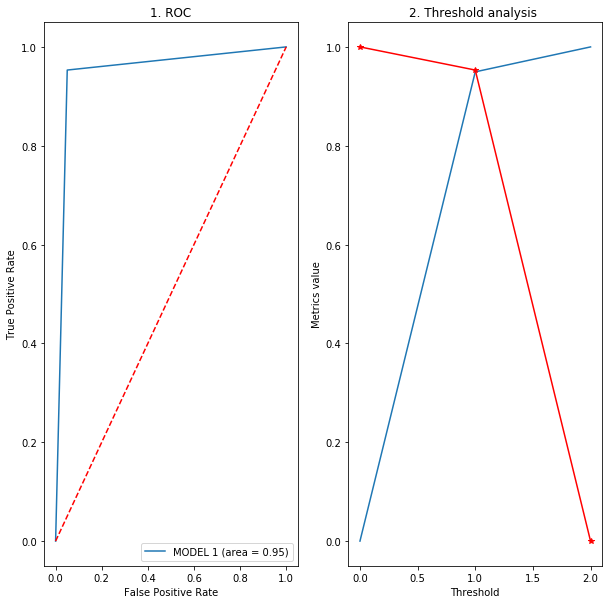

Prediction for model 2:
Confusion Matrix
[[305  12]
 [ 35 819]]
Classification Report
              precision    recall  f1-score   support

           1       0.90      0.96      0.93       317
           0       0.99      0.96      0.97       854

   micro avg       0.96      0.96      0.96      1171
   macro avg       0.94      0.96      0.95      1171
weighted avg       0.96      0.96      0.96      1171



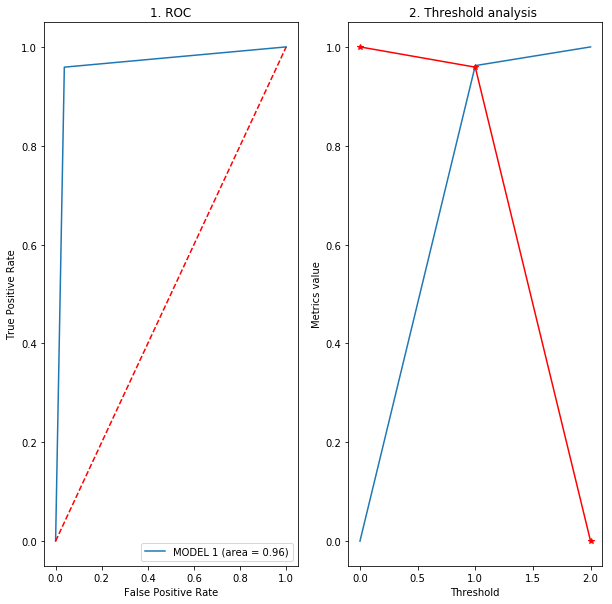

In [25]:
cutoff = 0.5 # this is the default decision boundary probability, we will modify it later.

#Call the last evaluation function:
EVALUATE.confusion_threshold_evaluation(cutoff)

We can see in the confusion matrix of model_0 that the number of true positives and true negatives is more extensive than in the other two models. We recognise that this model has classified the largest number of true negatives (831) than model_1 (814), at least 17 individuals. While the number of true positives was the lowest, but this lost was in the order of 3 individuals, which does not represent a significant loss. Another aspect observed from this analysis is that the area under the curve(AUC) was slighter bigger in model_0, while the threshold analyses pointed out to be better in model_1. A better "threshold analyses" according to Lukkarinen (2012) seems to be given by a balance between sensitivity and specificity. In conclusion, it appears to be an overall trend of benefits for model_0. Then the next step is to tune model_0 changing the decision boundary probability or cutoff:


Confusion Matrix
[[304  13]
 [ 31 823]]
Classification Report
              precision    recall  f1-score   support

           1       0.91      0.96      0.93       317
           0       0.98      0.96      0.97       854

   micro avg       0.96      0.96      0.96      1171
   macro avg       0.95      0.96      0.95      1171
weighted avg       0.96      0.96      0.96      1171



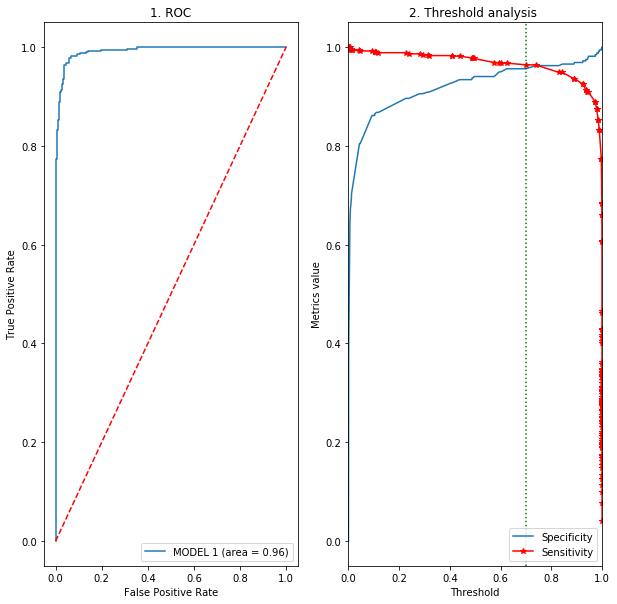

In [8]:
# First change in the decision boundary 0.5->0.7 (only for model_0)
cutoff = 0.7
Y_labels = test_generator.classes
Y_pred = loaded_model.predict_generator(test_generator)
Y_pred_prob = Y_pred # get a copy to speed the code, and avoid recalculation at line 17
Y_pred = 1*(Y_pred.astype('float64') > cutoff)

  
print('Confusion Matrix')
print(confusion_matrix(Y_labels, Y_pred))
print('Classification Report')
target_names = ['1','0']
print(classification_report(Y_labels, Y_pred, target_names=target_names))

logit_roc_auc = roc_auc_score(Y_labels, Y_pred)

#Y_pred_prob = loaded_model.predict_generator(test_generator).flatten()
fpr, tpr, thresholds = roc_curve(Y_labels, Y_pred_prob, pos_label = 1)


fig, axs = plt.subplots(1, 2, figsize=(10, 10))

axs[0].set_title('1. ROC')
axs[0].plot(fpr, tpr, label='MODEL 1 (area = %0.2f)' % logit_roc_auc)
axs[0].plot([0, 1], [0, 1],'r--')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].legend(loc="lower right")

axs[1].set_title('2. Threshold analysis ')
axs[1].plot(thresholds, 1- fpr,  label = 'Specificity')
axs[1].plot(thresholds, tpr, 'r*-', label = 'Sensitivity')
axs[1].set_xlabel('Threshold')
axs[1].set_ylabel('Metrics value')
axs[1].axvline(cutoff, color = 'green', linestyle = ":")
axs[1].set_xlim([0, 1])
axs[1].legend(loc="lower right")

plt.show()       

Using a desicion boundary = 0.7, we incremented the amount of true positives (6 patients) and deacrease the numbers 
true negatives (8). This is a net reduction of the correct classification of 2 patients (6 - 8 = 2).
Similarly F1 scores were reduced in 0.01 (not so significant), but the threshold analyses indicated a better 
balance between sensitivity and specificity.

In [13]:
test_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

Confusion Matrix
[[307  10]
 [ 58 796]]
Classification Report
              precision    recall  f1-score   support

           1       0.84      0.97      0.90       317
           0       0.99      0.93      0.96       854

   micro avg       0.94      0.94      0.94      1171
   macro avg       0.91      0.95      0.93      1171
weighted avg       0.95      0.94      0.94      1171



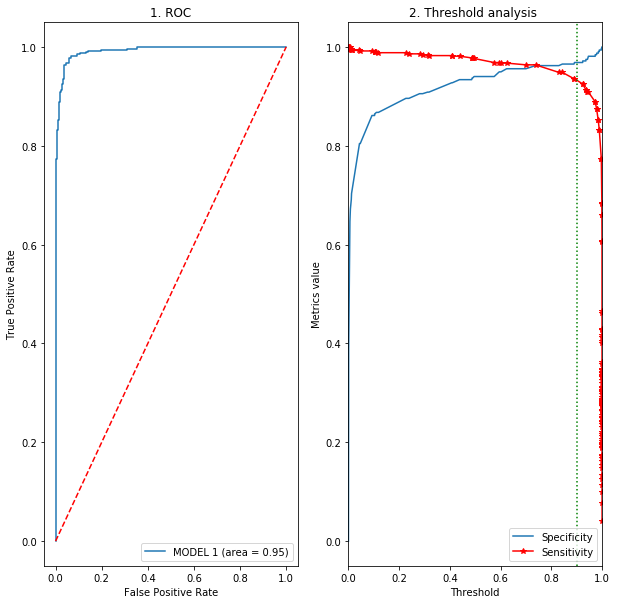

In [9]:
cutoff = 0.9 # incrementing the decision boundary from 0.7 -> 0.9
Y_labels = test_generator.classes
Y_pred = loaded_model.predict_generator(test_generator)
Y_pred_prob = Y_pred # get a copy to speed the code, and avoid recalculation
Y_pred = 1*(Y_pred.astype('float64') > cutoff)

  
print('Confusion Matrix')
print(confusion_matrix(Y_labels, Y_pred))
print('Classification Report')
target_names = ['1','0']
print(classification_report(Y_labels, Y_pred, target_names=target_names))

logit_roc_auc = roc_auc_score(Y_labels, Y_pred)

#Y_pred_prob = loaded_model.predict_generator(test_generator).flatten()
fpr, tpr, thresholds = roc_curve(Y_labels, Y_pred_prob, pos_label = 1)


fig, axs = plt.subplots(1, 2, figsize=(10, 10))

axs[0].set_title('1. ROC')
axs[0].plot(fpr, tpr, label='MODEL 1 (area = %0.2f)' % logit_roc_auc)
axs[0].plot([0, 1], [0, 1],'r--')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].legend(loc="lower right")

axs[1].set_title('2. Threshold analysis ')
axs[1].plot(thresholds, 1- fpr,  label = 'Specificity')
axs[1].plot(thresholds, tpr, 'r*-', label = 'Sensitivity')
axs[1].axvline(cutoff, color = 'green', linestyle = ":")
axs[1].set_xlabel('Threshold')
axs[1].set_ylabel('Metrics value')
axs[1].set_xlim([0, 1])
axs[1].legend(loc="lower right")

plt.show()       

The results above showed that the true negatives were reduced to 35. In contrast,
the true positive numbers were incremented in 9 patients; this gives a net gaining of (9 - 35 = 26 patients correctly which increased the number of false positives). We also observed and decreased in the F1 score average value, indicates a very strict decision boundary, and a slight loss in the balance of sensitivity and specificity.

Confusion Matrix
[[288  29]
 [ 14 840]]
Classification Report
              precision    recall  f1-score   support

           1       0.95      0.91      0.93       317
           0       0.97      0.98      0.98       854

   micro avg       0.96      0.96      0.96      1171
   macro avg       0.96      0.95      0.95      1171
weighted avg       0.96      0.96      0.96      1171



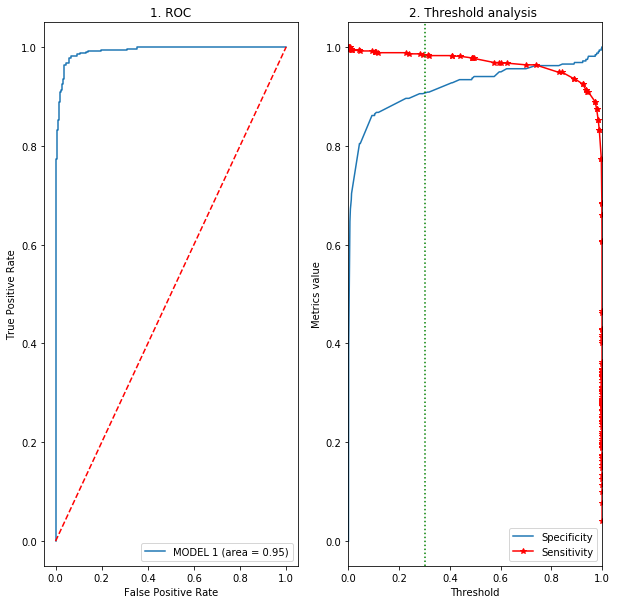

In [10]:

cutoff = 0.3 # we reduce the "decision boundary" from 0.5 -> 0.3
Y_labels = test_generator.classes
Y_pred = loaded_model.predict_generator(test_generator)
Y_pred_prob = Y_pred # get a copy to speed the code, and avoid recalculation
Y_pred = 1*(Y_pred.astype('float64') > cutoff)

  
print('Confusion Matrix')
print(confusion_matrix(Y_labels, Y_pred))
print('Classification Report')
target_names = ['1','0']
print(classification_report(Y_labels, Y_pred, target_names=target_names))

logit_roc_auc = roc_auc_score(Y_labels, Y_pred)

#Y_pred_prob = loaded_model.predict_generator(test_generator).flatten()
fpr, tpr, thresholds = roc_curve(Y_labels, Y_pred_prob, pos_label = 1)


fig, axs = plt.subplots(1, 2, figsize=(10, 10))

axs[0].set_title('1. ROC')
axs[0].plot(fpr, tpr, label='MODEL 1 (area = %0.2f)' % logit_roc_auc)
axs[0].plot([0, 1], [0, 1],'r--')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].legend(loc="lower right")

axs[1].set_title('2. Threshold analysis ')
axs[1].plot(thresholds, 1- fpr,  label = 'Specificity')
axs[1].plot(thresholds, tpr, 'r*-', label = 'Sensitivity')
axs[1].axvline(cutoff, color = 'green', linestyle = ":")
axs[1].set_xlabel('Threshold')
axs[1].set_ylabel('Metrics value')
axs[1].set_xlim([0, 1])
axs[1].legend(loc="lower right")

plt.show()       

With this decision boundary (0.3), we decreased the number of true positives and increased the number of true negatives: The sensitivity and F1 score remain the same and AUC did not change significantly (only 0.01).
Threshold analysis showed an imbalance between sensitivity and specificity. 

We conclude that a cutoff about 0.7 improves the classifier gaining two extra patients without losing in misclassification. Nevertheless looking at the first threshold analysis with cutoff = 0.7, it visually suggested that the cutoff should be located about 0.75, let see:

Confusion Matrix
[[305  12]
 [ 33 821]]
Classification Report
              precision    recall  f1-score   support

           1       0.90      0.96      0.93       317
           0       0.99      0.96      0.97       854

   micro avg       0.96      0.96      0.96      1171
   macro avg       0.94      0.96      0.95      1171
weighted avg       0.96      0.96      0.96      1171



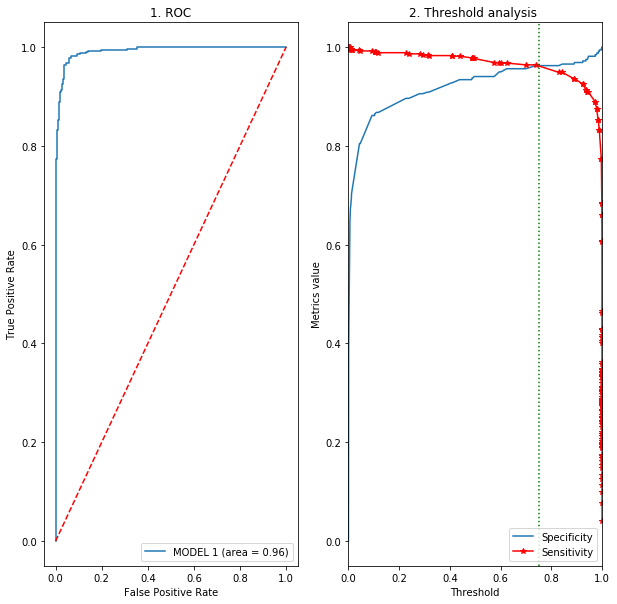

In [12]:
cutoff = 0.75 
Y_labels = test_generator.classes
Y_pred = loaded_model.predict_generator(test_generator)
Y_pred_prob = Y_pred # get a copy to speed the code, and avoid recalculation
Y_pred = 1*(Y_pred.astype('float64') > cutoff)

  
print('Confusion Matrix')
print(confusion_matrix(Y_labels, Y_pred))
print('Classification Report')
target_names = ['1','0']
print(classification_report(Y_labels, Y_pred, target_names=target_names))

logit_roc_auc = roc_auc_score(Y_labels, Y_pred)

#Y_pred_prob = loaded_model.predict_generator(test_generator).flatten()
fpr, tpr, thresholds = roc_curve(Y_labels, Y_pred_prob, pos_label = 1)


fig, axs = plt.subplots(1, 2, figsize=(10, 10))

axs[0].set_title('1. ROC')
axs[0].plot(fpr, tpr, label='MODEL 1 (area = %0.2f)' % logit_roc_auc)
axs[0].plot([0, 1], [0, 1],'r--')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].legend(loc="lower right")

axs[1].set_title('2. Threshold analysis ')
axs[1].plot(thresholds, 1- fpr,  label = 'Specificity')
axs[1].plot(thresholds, tpr, 'r*-', label = 'Sensitivity')
axs[1].axvline(cutoff, color = 'green', linestyle = ":")
axs[1].set_xlabel('Threshold')
axs[1].set_ylabel('Metrics value')
axs[1].set_xlim([0, 1])
axs[1].legend(loc="lower right")

plt.show()       

IV. Discusion

In this work, we build a classifier testing three CNNs, but modifying the batch size. 
We learnt that batch size influences the training time, making it longer as the batch becomes smaller, we also observed that metrics achieved by the model also change (accuracy, precision, recall, F1). For example, our model with the smallest batch size achieved the highest accuracy, precision and recall.
Gerón (2019) indicates that there is no general rule of thumb as to which batch size works out best, this is in agreement with Chollet (2017) who suggested to try few batch sizes and pick the one which works best. Nevertheless, both authors agree on not to use large batch sizes since it will tend to overfit the data, as we also see with our model_2 (batch size 64). 

  "Accuracy" and especially "loss" metrics are more reliable in analysing the fitting performance of models than precision and recall. 
  Recall/or sensitivity (also called the true positive rate) measures the proportion of actual positives that are correctly identified. At the same time, specificity (also called the true negative rate) measures the ratio of real negatives that are correctly identified as such. Therefore, a sound classifier should maximise sensitivity and specificity, and this should occur at a precise specific probability decision boundary or cutoff. Here we examined several threshold analyses plots and found that our model with a batch size = 8, and cutoff = 0.75 performs best, we gained high accuracy (over 94%) and sensitivity scores over 97%.
  Fitting CNN is a daunting task for inexperience analysts.

V. Bibliography

Chollet, F. 2017. Deep Learning with Python. Manning Publications Co. USA. 384 pages

Gerón, A. 2019. Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow. O'Reilly Media Inc. Sebastopol, CA, USA. 484 pages.

Hoorne, D. 2017. Python Machine Learning Case Studies. Apress.editors. Karachi, Pakistan, 205 pages.

Lukkarinen, S. 2012. Phonocardiography: Development of a clinical system and its application to screening for paediatric heart murmurs. Doctoral Disseration 128 pages

